In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime as dt

sys.path.append(os.path.abspath('../src/data'))
from extract_for_model import extract_time_series
#from extract_for_model import scale_time_series
#from extract_for_model import scale_time_series_single

from sklearn import tree
from sklearn.linear_model import Lasso
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.tree import export_graphviz  
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import BallTree


from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
#to do JeoJonson transformation
from scipy import stats

from statsmodels.compat import lzip
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split


In [2]:
# Import required paths to input files
# Change the file to import if needed
from data_links import soft_pub_IS as pub_input_IS
from data_links import soft_pub_BS as pub_input_BS

from data_links import soft_prv_IS as prv_input_IS
from data_links import soft_prv_BS as prv_input_BS

In [3]:
#create the data on new format, first using public software data
source = pub_input_IS

features = ['IQ_EBIT','IQ_TOTAL_OTHER_OPER','IQ_EARNING_CO','IQ_TOTAL_REV','IQ_GP','IQ_OTHER_OPER','IQ_INC_TAX','IQ_NET_INTEREST_EXP']

IS_train, IS_test = extract_time_series(input_path = source,\
                                          features = features,
                                             steps = 4,\
                                          year_min = 2012,\
                                              #norm = False,\
                                          no_shift = False,\
                                           quarterly=True)

# Read from Balance Sheets
features =  ['IQ_AR','IQ_RE','IQ_TOTAL_ASSETS','IQ_TOTAL_CL','IQ_TOTAL_EQUITY','IQ_TOTAL_LIAB_EQUITY']
source = pub_input_BS
BS_train, BS_test = extract_time_series(input_path = source,\
                                          features = features,
                                             steps = 4,\
                                          year_min = 2012,\
                                            # norm = False,\
                                          no_shift = False,\
                                           quarterly=True)


# Merge dataframes

train_df = IS_train.set_index(['company','year','quarter']).join(BS_train.set_index(['company','year','quarter']))
test_df  = IS_test.set_index(['company','year','quarter']).join(BS_test.set_index(['company','year','quarter']))

train_df = train_df.reset_index().dropna()
test_df  = test_df.reset_index().dropna()
data_set = pd.concat([train_df,test_df]).reset_index().dropna()

====  extract_time_series metric ====
Size of data read from the file: (16403, 11)
Size of RESHAPED data without NA: (7513, 51)
No of companies in RESHAPED data: 334
No of companies with more than 1 datapoint 309
TEST  set size: (309, 51)
TRAIN set size: (5370, 51)
TEST is 5% of all available datapoints
====  extract_time_series metric ====
Size of data read from the file: (16029, 9)
Size of RESHAPED data without NA: (11171, 39)
No of companies in RESHAPED data: 446
No of companies with more than 1 datapoint 430
TEST  set size: (430, 39)
TRAIN set size: (7902, 39)
TEST is 5% of all available datapoints


In [4]:
#create the data on new format, for the private data
source = prv_input_IS

features = ['IQ_EBIT','IQ_TOTAL_OTHER_OPER','IQ_EARNING_CO','IQ_TOTAL_REV','IQ_GP','IQ_OTHER_OPER','IQ_INC_TAX','IQ_NET_INTEREST_EXP']

IS_train, IS_test = extract_time_series(input_path = source,\
                                          features = features,
                                             steps = 1,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                           quarterly=True)

# Read from Balance Sheets
features =  ['IQ_AR','IQ_RE','IQ_TOTAL_ASSETS','IQ_TOTAL_CL','IQ_TOTAL_EQUITY','IQ_TOTAL_LIAB_EQUITY']
source = prv_input_BS
BS_train, BS_test = extract_time_series(input_path = source,\
                                          features = features,
                                             steps = 1,\
                                          year_min = 2012,\
                                          no_shift = False,\
                                           quarterly=True)


# Merge dataframes

train_df = IS_train.set_index(['company','year','quarter']).join(BS_train.set_index(['company','year','quarter']))
test_df  = IS_test.set_index(['company','year','quarter']).join(BS_test.set_index(['company','year','quarter']))

train_df = train_df.reset_index().dropna()
test_df  = test_df.reset_index().dropna()
data_private = pd.concat([train_df,test_df]).reset_index().dropna()
data_private.describe()


====  extract_time_series metric ====
Size of data read from the file: (2801, 11)
Size of RESHAPED data without NA: (1439, 27)
No of companies in RESHAPED data: 199
No of companies with more than 1 datapoint 186
TEST  set size: (186, 27)
TRAIN set size: (639, 27)
TEST is 23% of all available datapoints
====  extract_time_series metric ====
Size of data read from the file: (2802, 9)
Size of RESHAPED data without NA: (1191, 21)
No of companies in RESHAPED data: 149
No of companies with more than 1 datapoint 141
TEST  set size: (141, 21)
TRAIN set size: (530, 21)
TEST is 21% of all available datapoints


,index,year,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,IQ_TOTAL_REV-1,IQ_GP-1,IQ_OTHER_OPER-1,IQ_INC_TAX-1,IQ_NET_INTEREST_EXP-1,...,IQ_TOTAL_ASSETS+0,IQ_TOTAL_CL+0,IQ_TOTAL_EQUITY+0,IQ_TOTAL_LIAB_EQUITY+0,IQ_AR+1,IQ_RE+1,IQ_TOTAL_ASSETS+1,IQ_TOTAL_CL+1,IQ_TOTAL_EQUITY+1,IQ_TOTAL_LIAB_EQUITY+1
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,287.169312,2014.772487,2.526283,13.918929,1.369778,39.831974,16.445213,4.499059,0.566801,-0.095048,...,57.776412,22.014462,20.028719,57.776412,17.313247,8.250920,68.027505,25.447125,23.547690,68.027505
std,190.606899,1.697583,12.966966,25.372067,8.379235,111.556957,34.142580,14.253137,3.316579,2.902215,...,202.163352,69.513217,74.115480,202.163352,72.835806,62.094325,248.416458,79.046266,89.990666,248.416458
min,1.000000,2012.000000,-32.403350,0.135089,-38.471886,0.179212,0.148940,-4.835851,-6.169369,-23.881874,...,1.316924,0.514583,-14.556063,1.316924,0.001828,-71.395800,1.384725,0.737241,-25.956575,1.384725
25%,127.250000,2013.000000,-0.142696,3.231688,0.001340,4.560325,3.318438,0.067379,-0.155722,-0.003403,...,5.254446,2.079527,1.543851,5.254446,1.574418,-0.305324,6.091126,2.308226,1.649005,6.091126
50%,251.500000,2015.000000,0.265415,5.830673,0.318891,9.622959,6.023494,0.839041,0.001663,0.010292,...,9.588672,4.190039,3.914030,9.588672,3.053212,0.542648,11.354973,4.891358,4.285768,11.354973
75%,459.750000,2016.000000,1.274316,12.255238,1.202087,21.041620,13.596587,3.386388,0.227754,0.121314,...,30.631529,10.890141,10.869377,30.631529,8.087713,2.480074,36.180933,13.766234,11.751931,36.180933
max,638.000000,2017.000000,110.289380,241.389190,64.897810,739.338100,274.148160,163.694720,28.467388,15.652977,...,1781.078900,688.359500,776.672300,1781.078900,660.681340,692.339540,2683.770000,688.359500,899.565250,2683.770000


In [7]:
#aggregate data to the yearly level.
#This could be improved by summarising each feature independently depending on the origin. 
#for the purpose of these models is fine because we work with ratios and not with absolute values

data_agg=data_set.groupby(['year', 'company']).sum()
print(data_agg.columns)

Index(['index', 'IQ_EBIT-4', 'IQ_TOTAL_OTHER_OPER-4', 'IQ_EARNING_CO-4',
       'IQ_TOTAL_REV-4', 'IQ_GP-4', 'IQ_OTHER_OPER-4', 'IQ_INC_TAX-4',
       'IQ_NET_INTEREST_EXP-4', 'IQ_EBIT-3', 'IQ_TOTAL_OTHER_OPER-3',
       'IQ_EARNING_CO-3', 'IQ_TOTAL_REV-3', 'IQ_GP-3', 'IQ_OTHER_OPER-3',
       'IQ_INC_TAX-3', 'IQ_NET_INTEREST_EXP-3', 'IQ_EBIT-2',
       'IQ_TOTAL_OTHER_OPER-2', 'IQ_EARNING_CO-2', 'IQ_TOTAL_REV-2', 'IQ_GP-2',
       'IQ_OTHER_OPER-2', 'IQ_INC_TAX-2', 'IQ_NET_INTEREST_EXP-2', 'IQ_EBIT-1',
       'IQ_TOTAL_OTHER_OPER-1', 'IQ_EARNING_CO-1', 'IQ_TOTAL_REV-1', 'IQ_GP-1',
       'IQ_OTHER_OPER-1', 'IQ_INC_TAX-1', 'IQ_NET_INTEREST_EXP-1', 'IQ_EBIT+0',
       'IQ_TOTAL_OTHER_OPER+0', 'IQ_EARNING_CO+0', 'IQ_TOTAL_REV+0', 'IQ_GP+0',
       'IQ_OTHER_OPER+0', 'IQ_INC_TAX+0', 'IQ_NET_INTEREST_EXP+0', 'IQ_EBIT+1',
       'IQ_TOTAL_OTHER_OPER+1', 'IQ_EARNING_CO+1', 'IQ_TOTAL_REV+1', 'IQ_GP+1',
       'IQ_OTHER_OPER+1', 'IQ_INC_TAX+1', 'IQ_NET_INTEREST_EXP+1', 'IQ_AR-4',
       'IQ_RE

In [8]:
#create the ratios for the private dataset
#NEED TO CLEAN THIS PART, THERE ARE SOME DUPS THAT WERE DONE TO MATCH THE FEATURES NAMES IN THE MODEL
data_private['IQ_EBIT_AGG_perc']=(data_private['IQ_EBIT+0']-data_private['IQ_EBIT-1'])/data_private['IQ_EBIT-1']
data_private['IQ_TOTAL_ASSETS_AGG_perc']=(data_private['IQ_TOTAL_ASSETS+0']-data_private['IQ_TOTAL_ASSETS-1'])/data_private['IQ_TOTAL_ASSETS-1']
data_private['IQ_TOTAL_OTHER_OPER_AGG_perc']=(data_private['IQ_TOTAL_OTHER_OPER+0']-data_private['IQ_TOTAL_OTHER_OPER-1'])/data_private['IQ_TOTAL_OTHER_OPER-1']
data_private['IQ_TOTAL_REV_AGG_perc']=(data_private['IQ_TOTAL_REV+0']-data_private['IQ_TOTAL_REV-1'])/data_private['IQ_TOTAL_REV-1']
data_private['IQ_RE_AGG_perc']=(data_private['IQ_RE+0']-data_private['IQ_RE-1'])/data_private['IQ_RE-1']
data_private['IQ_EBIT_PERC_growth']=(data_private['IQ_EBIT+1']-data_private['IQ_EBIT+0'])/data_private['IQ_EBIT+0']
data_private['IQ_EBIT_PERC']=(data_private['IQ_EBIT+0']-data_private['IQ_EBIT-1'])/data_private['IQ_EBIT-1']
data_private['IQ_TOTAL_OTHER_OPER_PERC']=(data_private['IQ_TOTAL_OTHER_OPER+0']-data_private['IQ_TOTAL_OTHER_OPER-1'])/data_private['IQ_TOTAL_OTHER_OPER-1']
data_private['IQ_TOTAL_REV_PERC']=(data_private['IQ_TOTAL_REV+0']-data_private['IQ_TOTAL_REV-1'])/data_private['IQ_TOTAL_REV-1']
data_private['IQ_EARNING_CO_PERC']=(data_private['IQ_EARNING_CO+0']-data_private['IQ_EARNING_CO-1'])/data_private['IQ_EARNING_CO-1']
data_private['IQ_GP_PERC']=(data_private['IQ_GP+0']-data_private['IQ_GP-1'])/data_private['IQ_GP-1']
data_private['IQ_OTHER_OPER_PERC']=(data_private['IQ_OTHER_OPER+0']-data_private['IQ_OTHER_OPER-1'])/data_private['IQ_OTHER_OPER-1']
data_private['IQ_AR_PERC']=(data_private['IQ_AR+0']-data_private['IQ_AR-1'])/data_private['IQ_AR-1']
data_private['IQ_RE_PERC']=(data_private['IQ_RE+0']-data_private['IQ_RE-1'])/data_private['IQ_RE-1']
data_private['IQ_TOTAL_ASSETS_PERC']=(data_private['IQ_TOTAL_ASSETS+0']-data_private['IQ_TOTAL_ASSETS-1'])/data_private['IQ_TOTAL_ASSETS-1']

data_private=data_private.replace(np.nan, 0)
data_private=data_private.replace(np.inf, 0)
data_private.describe()

,index,year,IQ_EBIT-1,IQ_TOTAL_OTHER_OPER-1,IQ_EARNING_CO-1,IQ_TOTAL_REV-1,IQ_GP-1,IQ_OTHER_OPER-1,IQ_INC_TAX-1,IQ_NET_INTEREST_EXP-1,...,IQ_EBIT_PERC_growth,IQ_EBIT_PERC,IQ_TOTAL_OTHER_OPER_PERC,IQ_TOTAL_REV_PERC,IQ_EARNING_CO_PERC,IQ_GP_PERC,IQ_OTHER_OPER_PERC,IQ_AR_PERC,IQ_RE_PERC,IQ_TOTAL_ASSETS_PERC
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,...,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,287.169312,2014.772487,2.526283,13.918929,1.369778,39.831974,16.445213,4.499059,0.566801,-0.095048,...,-0.354815,-1.023506,0.240056,0.348986,-1.351185,0.302524,7.722639,0.887510,11.728741,0.561692
std,190.606899,1.697583,12.966966,25.372067,8.379235,111.556957,34.142580,14.253137,3.316579,2.902215,...,5.922339,14.855129,0.889631,1.760757,93.756944,1.324228,123.521376,7.615955,199.392408,4.108637
min,1.000000,2012.000000,-32.403350,0.135089,-38.471886,0.179212,0.148940,-4.835851,-6.169369,-23.881874,...,-58.967224,-250.585561,-0.717118,-0.968952,-1524.142397,-0.836934,-81.834788,-0.883737,-359.051095,-0.651211
25%,127.250000,2013.000000,-0.142696,3.231688,0.001340,4.560325,3.318438,0.067379,-0.155722,-0.003403,...,-0.875780,-0.836663,-0.042203,-0.035507,-0.764159,-0.054759,-0.320875,-0.126419,-0.296360,-0.029379
50%,251.500000,2015.000000,0.265415,5.830673,0.318891,9.622959,6.023494,0.839041,0.001663,0.010292,...,-0.019051,-0.087447,0.097614,0.108587,-0.113434,0.104932,0.080308,0.123370,0.096672,0.110890
75%,459.750000,2016.000000,1.274316,12.255238,1.202087,21.041620,13.596587,3.386388,0.227754,0.121314,...,0.511117,0.506949,0.294871,0.304133,0.538969,0.297672,0.523096,0.408601,0.563886,0.327778
max,638.000000,2017.000000,110.289380,241.389190,64.897810,739.338100,274.148160,163.694720,28.467388,15.652977,...,45.836782,45.836782,13.051522,21.250159,986.607565,17.696857,2364.342105,111.941264,3840.142857,75.694828


In [10]:
#ratios for the aggregate data
data_agg['IQ_EBIT_AGG_perc']=(data_agg['IQ_EBIT+0']-data_agg['IQ_EBIT-4'])/data_agg['IQ_EBIT-4']
data_agg['IQ_EBIT_AGG_growth_perc']=(data_agg['IQ_EBIT+0']-data_agg['IQ_EBIT-4'])/data_agg['IQ_EBIT+0']

data_agg['IQ_TOTAL_ASSETS_AGG_perc']=(data_agg['IQ_TOTAL_ASSETS+0']-data_agg['IQ_TOTAL_ASSETS-4'])/data_agg['IQ_TOTAL_ASSETS-4']
data_agg['IQ_TOTAL_OTHER_OPER_AGG_perc']=(data_agg['IQ_TOTAL_OTHER_OPER+0']-data_agg['IQ_TOTAL_OTHER_OPER-4'])/data_agg['IQ_TOTAL_OTHER_OPER-4']
data_agg['IQ_TOTAL_REV_AGG_perc']=(data_agg['IQ_TOTAL_REV+0']-data_agg['IQ_TOTAL_REV-4'])/data_agg['IQ_TOTAL_REV-4']
data_agg['IQ_RE_AGG_perc']=(data_agg['IQ_RE+0']-data_agg['IQ_RE-4'])/data_agg['IQ_RE-4']
data_agg['IQ_GP_AGG_perc']=(data_agg['IQ_GP+0']-data_agg['IQ_GP-4'])/data_agg['IQ_GP-4']
data_agg['IQ_AR_AGG_perc']=(data_agg['IQ_AR+0']-data_agg['IQ_AR-4'])/data_agg['IQ_AR-4']

data_agg=data_agg.replace(np.nan, 0)
data_agg=data_agg.replace(np.inf, 0)
data_agg.describe()
predictors = ['IQ_TOTAL_OTHER_OPER_AGG_perc','IQ_TOTAL_REV_AGG_perc','IQ_GP_AGG_perc',
             'IQ_AR_AGG_perc','IQ_RE_AGG_perc','IQ_TOTAL_ASSETS_AGG_perc', 'IQ_EBIT_AGG_perc','IQ_EBIT+0']
target     =  'IQ_EBIT_AGG_growth_perc'



In [11]:
#filter tails of the data set and rerun the models;
#this part is done after an analysis done in notebooK:NOTEBOOK NAME where the errors are studied

data_set2=data_agg[(data_agg['IQ_TOTAL_REV+0']<(5)) ]
data_set3=data_agg[(data_agg['IQ_TOTAL_REV+0']>=(5)) & (data_agg['IQ_TOTAL_REV+0']<10) ]
data_set4=data_agg[(data_agg['IQ_TOTAL_REV+0']<100) & (data_agg['IQ_TOTAL_REV+0']>=10) ]
data_set5=data_agg[(data_agg['IQ_TOTAL_REV+0']>=100) ]




In [12]:
#the following code creates train and test sets, a df with the actual values to transform back from ratio
#it then runs rf 
#fits the model with the public data
#does basic model analysis
#shows the importance of the different features to the model
#THIS CAN GO IN A FUNCTION, THE CODE IS REPEATED 4 TIMES

X_train, X_test, y_train, y_test = train_test_split(np.array(data_set2[predictors]), np.array(data_set2[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf1 = RandomForestRegressor(n_estimators=10,random_state = 0)
# Train the model on training data
rf1.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf1.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

rf1.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',




#fi = rf_feat_importance(rf, X_train)
#rf.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',

#train and test from first set of data


X_train, X_test, y_train, y_test = train_test_split(np.array(data_set3[predictors]), np.array(data_set3[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf2 = RandomForestRegressor(n_estimators=10,random_state = 0)
# Train the model on training data
rf2.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf2.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

#fi = rf_feat_importance(rf, X_train)
rf2.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',


#train and test from first set of data


X_train, X_test, y_train, y_test = train_test_split(np.array(data_set4[predictors]), np.array(data_set4[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf3 = RandomForestRegressor(n_estimators=10,random_state = 0)
# Train the model on training data
rf3.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf3.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

rf3.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',


print(X_train)
data_set3.head()

#train and test from first set of data

X_train, X_test, y_train, y_test = train_test_split(np.array(data_set5[predictors]), np.array(data_set5[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf4 = RandomForestRegressor(n_estimators=10,random_state = 0)
# Train the model on training data
rf4.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf4.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

#fi = rf_feat_importance(rf, X_train)
rf4.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',

Mean Absolute Error: 3.48 degrees.
0    0.145091
dtype: float64 mean absolute error
Mean Absolute Error: 3.63 degrees.
0    2.261439
dtype: float64 mean absolute error
Mean Absolute Error: 18.61 degrees.
0    0.091887
dtype: float64 mean absolute error
[[-5.09772462e-02 -1.22119563e-01 -2.21462308e-01 ... -1.01688373e-01
   4.18829220e-02 -7.44197302e-01]
 [ 5.16588462e-02  1.27682768e-01  5.66344045e-02 ... -2.00904752e+00
   8.51632315e-02  7.60510402e-02]
 [-3.60051250e-02  1.04269706e-01  1.66393519e-01 ...  5.75100403e+00
  -8.56229385e-02 -5.80745163e+00]
 ...
 [-2.41666584e-01 -1.32888475e-01 -2.19642284e-02 ...  9.77541640e-02
  -2.67031859e-01 -7.60430947e-01]
 [ 2.70851036e-01  3.27599133e-01  3.70596283e-01 ... -2.22444778e+00
   2.23881472e-01 -8.35815517e-01]
 [ 4.63939206e-02  3.31274666e-02  7.15214286e-02 ...  6.18175740e-02
  -3.47295042e-03  6.04364556e-01]]
Mean Absolute Error: 0.91 degrees.
0    231.316542
dtype: float64 mean absolute error


array([0.09350553, 0.0259297 , 0.22310214, 0.03844669, 0.16732472,
       0.04846255, 0.40322866])

In [13]:
#this part subsets the df to get the features that will be used in the KNN algorithm 
data_agg2=data_agg.loc[:, ['IQ_EBIT_AGG_perc','IQ_TOTAL_ASSETS_AGG_perc','IQ_TOTAL_OTHER_OPER_AGG_perc','IQ_TOTAL_REV_AGG_perc','IQ_RE_AGG_perc']]

data_private2=data_private.loc[:, ['IQ_EBIT_AGG_perc','IQ_TOTAL_ASSETS_AGG_perc','IQ_TOTAL_OTHER_OPER_AGG_perc','IQ_TOTAL_REV_AGG_perc','IQ_RE_AGG_perc']]

data_private2=data_private2.replace(np.nan, 0)

data_private2=data_private2.replace(np.inf, 0)
data_private2.head()

data_agg2=data_agg2.replace(np.nan, 0)

data_agg2=data_agg2.replace(np.inf, 0)
data_agg2.head()

IQ_EBIT_AGG_perc  IQ_TOTAL_ASSETS_AGG_perc  \
year   company                                                  
2012.0 IQ1004737          -0.306820                  0.001284   
       IQ10214670          0.165755                 -0.097723   
       IQ1034090           0.112381                 -0.076519   
       IQ10361568         -0.116195                 -0.213391   
       IQ1047789           1.678275                 -0.029631   

                   IQ_TOTAL_OTHER_OPER_AGG_perc  IQ_TOTAL_REV_AGG_perc  \
year   company                                                           
2012.0 IQ1004737                       0.615763               0.200799   
       IQ10214670                     -0.000472               0.049689   
       IQ1034090                      -0.139448              -0.067495   
       IQ10361568                      0.035534               0.100521   
       IQ1047789                       6.788316               0.306172   

                   IQ_RE_AGG_perc  
year   company                     
2012.0 IQ1004737        -0.298288  
       IQ10214670        0.249949  
       IQ1034090        -0.078741  
       IQ10361568        0.082457  
       IQ1047789        -0.075834

In [14]:
X = data_agg2.loc[:,'IQ_EBIT_AGG_perc':]

In [15]:
Y=data_private2.loc[:,'IQ_EBIT_AGG_perc':]

In [16]:
#create KNN with the data, using public data, BallTree algorithm.
#print the index of the nearest neighbour of the public data to the private data

tree = BallTree(X, leaf_size=2) 
dist, ind = tree.query(Y, k=1)                
Y['index']=ind


/home/lus_karol/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
#this loop finds the group of the private data based on which is the closest point on the public data
data_private['REV_group']=0
for i in range(0, len(Y)):
    index_number=int(Y.loc[i, 'index'])
    new=data_agg.iloc[[index_number]]
    revenue=float(new.loc[:, 'IQ_TOTAL_REV+0'])
    if revenue<(5):
        data_private.REV_group[[i]]=1
    if (revenue<10) & (revenue >=(5)):
        data_private.REV_group[[i]]=2
    if (revenue<100) & (revenue>=10):
        data_private.REV_group[[i]]=3
    if revenue>=100:
        data_private.REV_group[[i]]=4
Y.head()       

/home/lus_karol/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/lus_karol/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
/home/lus_karol/ENTER/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':
/home/lus_karol/ENTER/lib/python3.7/site-packages/

,IQ_EBIT_AGG_perc,IQ_TOTAL_ASSETS_AGG_perc,IQ_TOTAL_OTHER_OPER_AGG_perc,IQ_TOTAL_REV_AGG_perc,IQ_RE_AGG_perc,index
0,0.813676,0.410850,0.409243,0.453347,-1.367120,409
1,-0.884710,0.420775,0.453255,0.518506,0.332161,1323
2,-0.222683,0.400743,0.199457,0.213777,3.973273,1480
3,2.371602,0.430050,0.878308,1.169641,-0.035713,1156
4,1.038008,0.574117,0.257817,0.334466,0.623553,1159


In [18]:
data_private.groupby('REV_group').describe()

index                                                              \
           count        mean         std   min     25%    50%     75%    max   
REV_group                                                                      
1           70.0  327.600000  190.919089   1.0  155.75  317.5  510.75  636.0   
2           42.0  259.452381  196.646793   1.0  112.25  188.0  468.50  618.0   
3          189.0  280.026455  189.983158   6.0  125.00  232.0  452.00  638.0   
4           77.0  283.064935  186.837626  20.0  133.00  216.0  444.00  620.0   

            year               ... IQ_RE_PERC               \
           count         mean  ...        75%          max   
REV_group                      ...                           
1           70.0  2014.514286  ...   1.000149  3840.142857   
2           42.0  2014.666667  ...   0.326442    17.104161   
3          189.0  2014.899471  ...   0.513742    85.868817   
4           77.0  2014.753247  ...   0.623553   309.615983   

          IQ_TOTAL_ASSETS_PERC                                          \
                         count      mean       std       min       25%   
REV_group                                                                
1                         70.0  1.960891  9.354335 -0.651211 -0.052316   
2                         42.0  0.224974  0.712468 -0.328904 -0.064365   
3                        189.0  0.243837  0.500119 -0.594807 -0.019117   
4                         77.0  0.253545  1.090067 -0.358611 -0.035803   

                                          
                50%       75%        max  
REV_group                                 
1          0.136952  0.454509  75.694828  
2          0.057675  0.206692   3.331353  
3          0.115023  0.331015   2.911709  
4          0.081094  0.262449   9.441119  

[4 rows x 472 columns]

In [19]:
#the following four blocks calculate the errors from the private data fitted in the random forest regression created
#using the public data

columns = ['Segment','MAE','MSE']
segment_summary = pd.DataFrame(columns=columns)
# train and test from first set of data
data_private1=data_private[data_private.REV_group==1]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X1_test=data_private1.loc[:, predictors]
X1_test.head()
X1_prev=X1_test.iloc[:,7]
y1_test=data_private1.loc[:, target]
X1_test=data_private1.loc[:, predictors2]



X1_prev=pd.DataFrame(X1_prev)

  

predictions1 = rf1.predict(X1_test)
errors = abs(predictions1 - y1_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y1_test+1))*np.array(X1_prev)

predicted_real=(pd.DataFrame(predictions1)+1)*np.array(X1_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')
MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([1,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private2=data_private[data_private.REV_group==2]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X2_test=data_private2.loc[:, predictors]
X2_test.head()
X2_prev=X2_test.iloc[:,7]
y2_test=data_private2.loc[:, target]
X2_test=data_private2.loc[:, predictors2]



X2_prev=pd.DataFrame(X2_prev)

  

predictions2 = rf2.predict(X2_test)
errors = abs(predictions2 - y2_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y2_test+1))*np.array(X2_prev)

predicted_real=(pd.DataFrame(predictions2)+1)*np.array(X2_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')
MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([2,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private3=data_private[data_private.REV_group==3]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X3_test=data_private3.loc[:, predictors]
X3_test.head()
X3_prev=X3_test.iloc[:,7]
y3_test=data_private3.loc[:, target]
X3_test=data_private3.loc[:, predictors2]



X3_prev=pd.DataFrame(X3_prev)

  

predictions3 = rf3.predict(X3_test)
errors = abs(predictions3 - y3_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y3_test+1))*np.array(X3_prev)

predicted_real=(pd.DataFrame(predictions3)+1)*np.array(X3_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')

MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([3,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private4=data_private[data_private.REV_group==4]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X4_test=data_private4.loc[:, predictors]
X4_test.head()
X4_prev=X4_test.iloc[:,7]
y4_test=data_private4.loc[:, target]
X4_test=data_private4.loc[:, predictors2]



X4_prev=pd.DataFrame(X4_prev)

  

predictions4 = rf4.predict(X4_test)
errors = abs(predictions4 - y4_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y4_test+1))*np.array(X4_prev)

predicted_real=(pd.DataFrame(predictions4)+1)*np.array(X4_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')

MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([4,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)


Mean Absolute Error: 4.47 degrees.
3.153238240502022 mean absolute error
Mean Absolute Error: 3.96 degrees.
1.944742201117409 mean absolute error
Mean Absolute Error: 2.59 degrees.
2.5407814432223734 mean absolute error
Mean Absolute Error: 4.67 degrees.
3.785210760934891 mean absolute error


In [20]:
# Create filters for data segmentation
#data_set2; data_set3; data_set4; data_set5
#data_private1; data_private2; data_private3; data_private4
# ****************************
predictors = ['IQ_TOTAL_OTHER_OPER_AGG_perc','IQ_TOTAL_REV_AGG_perc','IQ_GP_AGG_perc',
             'IQ_AR_AGG_perc','IQ_RE_AGG_perc','IQ_TOTAL_ASSETS_AGG_perc', 'IQ_EBIT_AGG_perc','IQ_EBIT+0']
target     =  'IQ_EBIT_AGG_growth_perc'



res = data_agg2
target_name = 'IQ_TOTAL_REV+0'

mask1 = data_set2
mask2 = data_set3
mask3 = data_set4
mask4 = data_set5 
masks=[mask1, mask2, mask3, mask4]
# ****************************
# Hyperparameter optimization
# ****************************
#
#  Varies selected hyper-parameters and collects them to the dictionary
#
n_estimator_range = [10,100,200,400,800,1600]
criteria = ['mse','mae']
max_depths = [1,3,5,7,9,11]

opti_results ={}
for n_est in n_estimator_range:
    for max_depth in max_depths:
        for criterion in criteria:
            for idx,mask in enumerate(masks):
                segment = idx+1
                #
                #
                res = mask.copy()
                X_train, X_test, y_train, y_test = train_test_split(np.array(mask[predictors]), np.array(mask[target]), test_size=0.33, random_state=42)
                X_previous = X_test[:,7]
                X_train = np.delete(X_train, -1, axis=1)
                X_test = np.delete(X_test, -1,axis=1)
                X_previous = pd.DataFrame(X_previous)  
                #
                rf = RandomForestRegressor(n_estimators=n_est,
                                           criterion=criterion,
                                           max_depth=max_depth,
                                           random_state = 0)
                rf.fit(X_train, y_train)
                predictions = rf.predict(X_test)
                #
                real_val=(pd.DataFrame(y_test+1))*X_previous
                predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
                #
                #export_graphviz(rf.estimators_[0], out_file='tree_from_forest_private_seg_'+str(idx)+'.dot')
                #
                MSE = mse(real_val,predicted_real)
                MAE = mae(real_val,predicted_real)
                row = pd.Series([segment,MAE,MSE])
                #
                key_tuple = (segment,n_est,max_depth,criterion)
                #              
                opti_results[key_tuple] = row
                print("{} : {}".format(key_tuple,row) )

(1, 10, 1, 'mse') : 0    1.000000
1    0.804136
2    2.071358
dtype: float64
(2, 10, 1, 'mse') : 0     2.000000
1     1.990949
2    28.149227
dtype: float64
(3, 10, 1, 'mse') : 0     3.000000
1     2.585104
2    18.236470
dtype: float64
(4, 10, 1, 'mse') : 0        4.000000
1       24.760651
2    11291.162932
dtype: float64
(1, 10, 1, 'mae') : 0    1.000000
1    0.456961
2    0.673459
dtype: float64
(2, 10, 1, 'mae') : 0     2.000000
1     1.732166
2    21.820676
dtype: float64
(3, 10, 1, 'mae') : 0    3.000000
1    1.373600
2    5.593625
dtype: float64
(4, 10, 1, 'mae') : 0        4.000000
1       36.562815
2    61584.252777
dtype: float64
(1, 10, 3, 'mse') : 0    1.000000
1    0.297259
2    0.549104
dtype: float64
(2, 10, 3, 'mse') : 0     2.000000
1     1.974882
2    38.289128
dtype: float64
(3, 10, 3, 'mse') : 0    3.000000
1    1.153183
2    4.428098
dtype: float64
(4, 10, 3, 'mse') : 0    4.000000e+00
1    2.362145e+02
2    4.487934e+06
dtype: float64
(1, 10, 3, 'mae') : 0    1.0

(3, 200, 1, 'mae') : 0    3.000000
1    1.361276
2    5.548571
dtype: float64
(4, 200, 1, 'mae') : 0        4.000000
1       20.236188
2    10340.761611
dtype: float64
(1, 200, 3, 'mse') : 0    1.000000
1    0.386130
2    0.951728
dtype: float64
(2, 200, 3, 'mse') : 0      2.000000
1      3.062635
2    110.505736
dtype: float64
(3, 200, 3, 'mse') : 0    3.000000
1    1.035786
2    3.802472
dtype: float64
(4, 200, 3, 'mse') : 0        4.000000
1       30.057394
2    21479.109297
dtype: float64
(1, 200, 3, 'mae') : 0    1.000000
1    0.201036
2    0.228601
dtype: float64
(2, 200, 3, 'mae') : 0    2.000000
1    1.080788
2    7.615123
dtype: float64
(3, 200, 3, 'mae') : 0    3.000000
1    0.608439
2    1.658677
dtype: float64
(4, 200, 3, 'mae') : 0        4.000000
1       21.584410
2    30314.837374
dtype: float64
(1, 200, 5, 'mse') : 0    1.000000
1    0.234972
2    0.661729
dtype: float64
(2, 200, 5, 'mse') : 0      2.000000
1      2.812558
2    107.693642
dtype: float64
(3, 200, 5, 'mse

(4, 800, 3, 'mse') : 0       4.000000
1      19.543292
2    7875.150175
dtype: float64
(1, 800, 3, 'mae') : 0    1.000000
1    0.203999
2    0.245578
dtype: float64
(2, 800, 3, 'mae') : 0    2.000000
1    1.029427
2    6.110733
dtype: float64
(3, 800, 3, 'mae') : 0    3.000000
1    0.607512
2    1.652135
dtype: float64
(4, 800, 3, 'mae') : 0        4.000000
1       22.864273
2    36057.173613
dtype: float64
(1, 800, 5, 'mse') : 0    1.000000
1    0.234788
2    0.650866
dtype: float64
(2, 800, 5, 'mse') : 0      2.000000
1      2.850620
2    105.089186
dtype: float64
(3, 800, 5, 'mse') : 0    3.000000
1    0.239197
2    0.289288
dtype: float64
(4, 800, 5, 'mse') : 0       4.000000
1      15.940148
2    9470.845371
dtype: float64
(1, 800, 5, 'mae') : 0    1.000000
1    0.132758
2    0.238787
dtype: float64
(2, 800, 5, 'mae') : 0    2.000000
1    0.880645
2    5.013073
dtype: float64
(3, 800, 5, 'mae') : 0    3.000000
1    0.124304
2    0.133635
dtype: float64
(4, 800, 5, 'mae') : 0      

In [21]:
# Print the results sorted by error for each segment:
columns     = ['Segment','Hyper','MAE','MSE']
opti_sum_pd = pd.DataFrame(columns=columns)

for k,v in sorted(opti_results.items(),key = lambda kv: (kv[1][1],kv[1][2])):
    row = pd.Series([k[0],k[1:],v[1],v[2]],index = columns)
    opti_sum_pd = opti_sum_pd.append(row,ignore_index=True)
    
for segment in opti_sum_pd['Segment'].unique():
    print(opti_sum_pd[opti_sum_pd['Segment']==segment])

    Segment            Hyper       MAE        MSE
0         3     (10, 9, mae)  0.059481   0.100862
1         3  (1600, 11, mae)  0.059953   0.111247
2         3   (1600, 9, mae)  0.061101   0.111517
3         3    (400, 9, mae)  0.062203   0.111372
4         3   (400, 11, mae)  0.062305   0.111246
5         3   (800, 11, mae)  0.062435   0.116242
6         3    (800, 9, mae)  0.063316   0.116117
7         3    (10, 11, mae)  0.065280   0.107203
8         3   (1600, 7, mae)  0.069424   0.113174
9         3    (400, 7, mae)  0.069605   0.111637
10        3    (200, 9, mae)  0.071118   0.136368
11        3    (800, 7, mae)  0.071658   0.118121
12        3   (200, 11, mae)  0.072304   0.137884
13        3    (100, 9, mae)  0.075792   0.155480
14        3   (100, 11, mae)  0.075901   0.157483
15        3    (200, 7, mae)  0.078405   0.137575
16        3    (400, 9, mse)  0.079598   0.150947
17        3     (10, 7, mae)  0.079957   0.109665
18        3    (100, 7, mae)  0.084257   0.159355


In [22]:
#repeate the model fitting using the hyperparameters from above, taking the first rwo of hyper from the model
#the following code creates train and test sets, a df with the actual values to transform back from ratio
#it then runs rf 
#fits the model with the public data
#does basic model analysis
#shows the importance of the different features to the model
#THIS CAN GO IN A FUNCTION, THE CODE IS REPEATED 4 TIMES

X_train, X_test, y_train, y_test = train_test_split(np.array(data_set2[predictors]), np.array(data_set2[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf1 = RandomForestRegressor(n_estimators=10,random_state = 0, max_depth=1)
# Train the model on training data
rf1.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf1.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

rf1.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',




#fi = rf_feat_importance(rf, X_train)
#rf.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',

#train and test from first set of data


X_train, X_test, y_train, y_test = train_test_split(np.array(data_set3[predictors]), np.array(data_set3[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf2 = RandomForestRegressor(n_estimators=800,random_state = 0, max_depth=1)
# Train the model on training data
rf2.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf2.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

#fi = rf_feat_importance(rf, X_train)
rf2.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',


#train and test from first set of data


X_train, X_test, y_train, y_test = train_test_split(np.array(data_set4[predictors]), np.array(data_set4[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf3 = RandomForestRegressor(n_estimators=200,random_state = 0, max_depth=1)
# Train the model on training data
rf3.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf3.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

rf3.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',


print(X_train)
data_set3.head()

#train and test from first set of data

X_train, X_test, y_train, y_test = train_test_split(np.array(data_set5[predictors]), np.array(data_set5[target]), test_size=0.33, random_state=42)

X_previous=X_test[:,7]
X_train=np.delete(X_train, -1, axis=1)
X_test=np.delete(X_test, -1,axis=1)
X_train.shape
X_previous
X_previous=pd.DataFrame(X_previous)

  
# Instantiate model with 1000 decision trees
rf4 = RandomForestRegressor(n_estimators=10,random_state = 0, max_depth=1)
# Train the model on training data
rf4.fit(X_train, y_train)

# Use the forest's predict method on the test data
predictions = rf4.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y_test+1))*X_previous

predicted_real=(pd.DataFrame(predictions)+1)*(X_previous)
errors_real_val=abs(predicted_real-real_val)
print(np.mean(errors_real_val), 'mean absolute error')

#fi = rf_feat_importance(rf, X_train)
rf4.feature_importances_

#['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
 #            'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC',

Mean Absolute Error: 5.11 degrees.
0    0.804136
dtype: float64 mean absolute error
Mean Absolute Error: 4.87 degrees.
0    3.047145
dtype: float64 mean absolute error
Mean Absolute Error: 19.73 degrees.
0    2.51271
dtype: float64 mean absolute error
[[-5.09772462e-02 -1.22119563e-01 -2.21462308e-01 ... -1.01688373e-01
   4.18829220e-02 -7.44197302e-01]
 [ 5.16588462e-02  1.27682768e-01  5.66344045e-02 ... -2.00904752e+00
   8.51632315e-02  7.60510402e-02]
 [-3.60051250e-02  1.04269706e-01  1.66393519e-01 ...  5.75100403e+00
  -8.56229385e-02 -5.80745163e+00]
 ...
 [-2.41666584e-01 -1.32888475e-01 -2.19642284e-02 ...  9.77541640e-02
  -2.67031859e-01 -7.60430947e-01]
 [ 2.70851036e-01  3.27599133e-01  3.70596283e-01 ... -2.22444778e+00
   2.23881472e-01 -8.35815517e-01]
 [ 4.63939206e-02  3.31274666e-02  7.15214286e-02 ...  6.18175740e-02
  -3.47295042e-03  6.04364556e-01]]
Mean Absolute Error: 0.29 degrees.
0    24.760651
dtype: float64 mean absolute error


array([0.1, 0. , 0.3, 0. , 0.1, 0. , 0.5])

In [23]:
#the following four blocks calculate the errors from the private data fitted in the random forest regression created
#using the public data

columns = ['Segment','MAE','MSE']
segment_summary = pd.DataFrame(columns=columns)
# train and test from first set of data
data_private1=data_private[data_private.REV_group==1]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X1_test=data_private1.loc[:, predictors]
X1_test.head()
X1_prev=X1_test.iloc[:,7]
y1_test=data_private1.loc[:, target]
X1_test=data_private1.loc[:, predictors2]



X1_prev=pd.DataFrame(X1_prev)

  

predictions1 = rf1.predict(X1_test)
errors = abs(predictions1 - y1_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y1_test+1))*np.array(X1_prev)

predicted_real=(pd.DataFrame(predictions1)+1)*np.array(X1_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')
MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([1,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private2=data_private[data_private.REV_group==2]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X2_test=data_private2.loc[:, predictors]
X2_test.head()
X2_prev=X2_test.iloc[:,7]
y2_test=data_private2.loc[:, target]
X2_test=data_private2.loc[:, predictors2]



X2_prev=pd.DataFrame(X2_prev)

  

predictions2 = rf2.predict(X2_test)
errors = abs(predictions2 - y2_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y2_test+1))*np.array(X2_prev)

predicted_real=(pd.DataFrame(predictions2)+1)*np.array(X2_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')
MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([2,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private3=data_private[data_private.REV_group==3]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X3_test=data_private3.loc[:, predictors]
X3_test.head()
X3_prev=X3_test.iloc[:,7]
y3_test=data_private3.loc[:, target]
X3_test=data_private3.loc[:, predictors2]



X3_prev=pd.DataFrame(X3_prev)

  

predictions3 = rf3.predict(X3_test)
errors = abs(predictions3 - y3_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y3_test+1))*np.array(X3_prev)

predicted_real=(pd.DataFrame(predictions3)+1)*np.array(X3_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')

MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([3,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary 

# train and test from first set of data
data_private4=data_private[data_private.REV_group==4]


predictors = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC','IQ_EBIT+0']
target     =  'IQ_EBIT_PERC_growth'
predictors2 = ['IQ_TOTAL_OTHER_OPER_PERC','IQ_TOTAL_REV_PERC','IQ_GP_PERC',
             'IQ_AR_PERC','IQ_RE_PERC','IQ_TOTAL_ASSETS_PERC', 'IQ_EBIT_PERC']


X4_test=data_private4.loc[:, predictors]
X4_test.head()
X4_prev=X4_test.iloc[:,7]
y4_test=data_private4.loc[:, target]
X4_test=data_private4.loc[:, predictors2]



X4_prev=pd.DataFrame(X4_prev)

  

predictions4 = rf4.predict(X4_test)
errors = abs(predictions4 - y4_test)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


real_val=(pd.DataFrame(y4_test+1))*np.array(X4_prev)

predicted_real=(pd.DataFrame(predictions4)+1)*np.array(X4_prev)
errors_real_val=abs(np.array(predicted_real)-np.array(real_val))
print(np.mean(errors_real_val), 'mean absolute error')

MSE = mse(real_val,predicted_real)
MAE = mae(real_val,predicted_real)
row = pd.Series([4,MAE,MSE],index=columns)
segment_summary = segment_summary.append(row,ignore_index=True)
segment_summary

Mean Absolute Error: 3.95 degrees.
4.1052328936070905 mean absolute error
Mean Absolute Error: 4.39 degrees.
2.049687264169547 mean absolute error
Mean Absolute Error: 2.54 degrees.
2.7041986064311234 mean absolute error
Mean Absolute Error: 2.42 degrees.
3.26661783576262 mean absolute error


,Segment,MAE,MSE
0,1.0,4.105233,139.247624
1,2.0,2.049687,28.107372
2,3.0,2.704199,43.897812
3,4.0,3.266618,47.430050


In [24]:

#columns = ['Segment','MAE','MSE']
#importances_summary = pd.DataFrame(columns=['segment', 'feature1', 'feature2', 'feature3', 'feature4'
                                         #  ,'feature5', 'feature6', 'feature7'])
importances1 = rf1.feature_importances_
#importances1=importances1.rename(columns={0: "model1"})

importances2 = rf2.feature_importances_
#importances2=importances2.rename(columns={0: "model2"})

importances3 = rf3.feature_importances_
#importances3=importances3.rename(columns={0: "model3"})

importances4 = rf4.feature_importances_
#importances4=importances4.rename(columns={0: "model4"})

#row = pd.Series([3,importances],index=columns)
#importances_summary = importances_summary.append(row,ignore_index=True)

#frames = [importances1, importances2, importances3, importances4]

#importances = pd.concat(frames, axis=1)

#importances


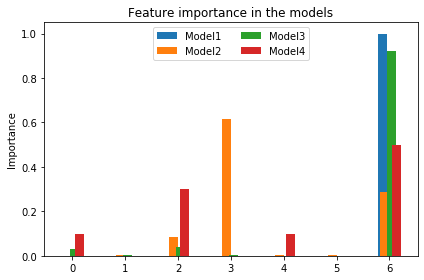

In [25]:
labels = ['G1', 'G2', 'G3', 'G4', 'G5']
men_means = [20, 34, 30, 35, 27]
women_means = [25, 32, 34, 20, 25]

x = np.arange(len(importances1))  # the label locations
width = 0.17  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - 3*width/4, importances1, width, label='Model1')
rects2 = ax.bar(x - width/2, importances2, width, label='Model2')
rects3 = ax.bar(x + width/4, importances3, width, label='Model3')
rects4 = ax.bar(x + 3*width/4, importances4, width, label='Model4')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Importance')
ax.set_title('Feature importance in the models')
ax.set_xticks(x)
#ax.set_xticklabels(labels)
ax.legend(loc='upper center', ncol=2)


fig.tight_layout()

plt.show()